# Import Statements

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import random
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA 
import math

random.seed(45)

# Train test split

In [2]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size*len(df))#Calculating the test size 

    indices = df.index.tolist()
    test_indices = random.sample(population = indices, k = test_size)#Random sampling of data

    test_df = df.loc[test_indices]#Getting the test data set
    train_df = df.drop(test_indices)#Getting the train data set
    return train_df, test_df


# Handling missing values

In [3]:
def handle_missing_values(df):
    #Columns with missing values: Bed Grade, City_Code_Patient
    
    # Method 1.Replacing with most common value
    df["Bed Grade"].fillna(df["Bed Grade"].value_counts().index[0], inplace=True)
    df["City_Code_Patient"].fillna(df["City_Code_Patient"].value_counts().index[0], inplace=True)
    

# Encoding categorical variables

In [4]:
def encode_data(df):
    cleanup_nums = {"Department":     {"gynecology": 0, "anesthesia": 1, "radiotherapy": 2, "TB & Chest disease": 3, "surgery": 4 },
                "Ward_Type": {"R": 0, "Q": 1, "S": 2, "P": 3, "T": 4, "U": 5 },
                "Type of Admission": {"Trauma": 0, "Emergency": 1, "Urgent": 2 },
                "Severity of Illness": {"Minor": 0, "Moderate": 1, "Extreme": 2},
                "Age": {"0-10": 0, "11-20": 1, "21-30": 2, "31-40": 3, "41-50": 4, "51-60": 5, "61-70": 6, "71-80": 7, "81-90": 8, "91-100": 9},
                "Stay": {"0-10": 0, "11-20": 1, "21-30": 2, "31-40": 3, "41-50": 4, "51-60": 5, "61-70": 6, "71-80": 7, "81-90": 8, "91-100": 9, "More than 100 Days": 10}, 
                "Hospital_type_code": {"a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6}, 
                "Hospital_region_code": {"X": 0, "Y": 1, "Z": 2}, 
                "Ward_Facility_Code": {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5}}

    df.replace(cleanup_nums, inplace=True)
    return df

# Train using Naive Bayes Classifier

In [5]:
def train(df,target, attributes):

    label_classes = df[target].unique()
    '''
    Data structure used to store probabilities : Dictionary of dictionary of one dimensional arrays.
    Element prob_dict[k][j][i] stores probability of occurence of jth value of kth attribute given that ith class is TRUE
    
    Simpler Format : prob_dict[attribute][attr_value][class]

    '''
    prob_dict = {}    #Main Dictionary 

    for attribute in attributes:
        print(attribute)
        attr_values = df[attribute].unique()
        conditional_prob_dict = {}                #Stores For all attr_value -> [ P(attr_value | class1), P(attr_value | class2), P(attr_value | class3)]
        
        for attr_value in attr_values:
            conditional_prob = {}
            for label_class in label_classes:  
                df_filtered=df[df[target]==label_class]
                denominator=len(df_filtered)
                df_filtered1=df_filtered[df_filtered[attribute]==attr_value]
                numerator = len(df_filtered1)+ 1  #Adding 1 to avoid zero proabability
                
                probability = numerator / denominator
                
                conditional_prob[label_class]=probability

            conditional_prob_dict[attr_value] = conditional_prob       #[ P(attr_value | class1), P(attr_value | class2), P(attr_value | class3)]

        prob_dict[attribute] = conditional_prob_dict

        #Calculating class probabilities
        prob_class={}
        for label_class in label_classes:
            prob_class[label_class] = (df[df[target] == label_class].shape[0] / df.shape[0])

    return prob_dict,prob_class

# Prediction and Accuracy

In [6]:
def predict(prob_dict,prob_class,attributes,label_classes,datapoint,df):
    prob_max=0
    for label_class in label_classes:
        prob=1
        for attribute in attributes:
            try:
                prob = prob * prob_dict[attribute][datapoint[attribute]][label_class]
            except KeyError:
                prob=1/len(df)
      
        prob=prob*prob_class[label_class]
      
        if prob > prob_max:
            prob_max = prob
            label = label_class

    return label

def getPrediction(prob_dict,prob_class,attributes,label_classes,test,df):
    preds=[]
    for i in range(0,len(test)):
        #print(i)
        preds.append(predict(prob_dict,prob_class,attributes,label_classes,test.iloc[i],df))
    return preds

def getAccuracy(preds,labels):
    if len(preds) != len(labels):
        print("Shape of Actual label array & predicted label array should be same.")
        exit(1)
     
    correct_count=0
    for i in range(0,len(preds)):
        #print(i)
        if(preds[i]==labels[i]):
            correct_count+=1

    return correct_count/len(preds)

In [7]:
#Helper function
def createBin(x,max_val):
    frac = x/max_val
    if frac < 0.25:
        return 0
    elif frac >=0.25 and frac < 0.5:
        return 1
    elif frac >=0.5 and frac < 0.75:
        return 2
    else:
        return 3
df=pd.read_csv("Train_B.csv")
handle_missing_values(df)

#converting continuous feature into categorical
feature="Admission_Deposit"
max_val = df[feature].max()
df[feature] = df[feature].apply(lambda x: createBin(x,max_val))
target=df.columns[-1]
label_classes=df[target].unique()
df.drop(['case_id','patientid'], axis=1, inplace=True)

'''Performing 5 fold cross validation'''

rem_df, test_df_1 = train_test_split(df,0.2)
rem_df, test_df_2 = train_test_split(rem_df, 0.25)
rem_df, test_df_3 = train_test_split(rem_df, 0.33)
test_df_5, test_df_4 = train_test_split(rem_df, 0.50)

indices = test_df_1.index.tolist()
train_df_1 = df.drop(indices)

indices = test_df_2.index.tolist()
train_df_2 = df.drop(indices)

indices = test_df_3.index.tolist()
train_df_3 = df.drop(indices)

indices = test_df_4.index.tolist()
train_df_4 = df.drop(indices)

indices = test_df_5.index.tolist()
train_df_5 = df.drop(indices)


print("Training started...")
attributes=train_df_1.columns[:-1].tolist()
probs,prob_class = train(train_df_1,target,attributes)
print("Training completed.")

print("Prediction started...")
preds = getPrediction(probs,prob_class,attributes,label_classes,test_df_1,df)
print("Prediction completed...")
print("Getting accuracy...")
acc = getAccuracy(preds,test_df_1[target].tolist())

print("Accuracy 1 = ",acc)


print("Training started...")
attributes=train_df_2.columns[:-1].tolist()
probs,prob_class = train(train_df_2,target,attributes)
print("Training completed.")

print("Prediction started...")
preds = getPrediction(probs,prob_class,attributes,label_classes,test_df_2,df)
print("Prediction completed...")
print("Getting accuracy...")
acc = getAccuracy(preds,test_df_2[target].tolist())

print("Accuracy 2 = ",acc)


print("Training started...")
attributes=train_df_3.columns[:-1].tolist()
probs,prob_class = train(train_df_3,target,attributes)
print("Training completed.")

print("Prediction started...")
preds = getPrediction(probs,prob_class,attributes,label_classes,test_df_3,df)
print("Prediction completed...")
print("Getting accuracy...")
acc = getAccuracy(preds,test_df_3[target].tolist())

print("Accuracy 3 = ",acc)


print("Training started...")
attributes=train_df_4.columns[:-1].tolist()
probs,prob_class = train(train_df_4,target,attributes)
print("Training completed.")

print("Prediction started...")
preds = getPrediction(probs,prob_class,attributes,label_classes,test_df_4,df)
print("Prediction completed...")
print("Getting accuracy...")
acc = getAccuracy(preds,test_df_4[target].tolist())

print("Accuracy 4 = ",acc)


print("Training started...")
attributes=train_df_5.columns[:-1].tolist()
probs,prob_class = train(train_df_5,target,attributes)
print("Training completed.")

print("Prediction started...")
preds = getPrediction(probs,prob_class,attributes,label_classes,test_df_5,df)
print("Prediction completed...")
print("Getting accuracy...")
acc = getAccuracy(preds,test_df_5[target].tolist())

print("Accuracy 5 = ",acc)

Training started...
Hospital_code
Hospital_type_code
City_Code_Hospital
Hospital_region_code
Available Extra Rooms in Hospital
Department
Ward_Type
Ward_Facility_Code
Bed Grade
City_Code_Patient
Type of Admission
Severity of Illness
Visitors with Patient
Age
Admission_Deposit
Training completed.
Prediction started...
Prediction completed...
Getting accuracy...
Accuracy 1 =  0.34588933551061424
Training started...
Hospital_code
Hospital_type_code
City_Code_Hospital
Hospital_region_code
Available Extra Rooms in Hospital
Department
Ward_Type
Ward_Facility_Code
Bed Grade
City_Code_Patient
Type of Admission
Severity of Illness
Visitors with Patient
Age
Admission_Deposit
Training completed.
Prediction started...
Prediction completed...
Getting accuracy...
Accuracy 2 =  0.3460777540509986
Training started...
Hospital_code
Hospital_type_code
City_Code_Hospital
Hospital_region_code
Available Extra Rooms in Hospital
Department
Ward_Type
Ward_Facility_Code
Bed Grade
City_Code_Patient
Type of Admi

In [8]:
df = encode_data(df)

In [9]:
df.head(25)

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,2,3,2,3,2,0,5,2.0,7.0,1,2,2,5,1,0
1,2,2,5,2,2,2,2,5,2.0,7.0,0,2,2,5,2,4
2,10,4,1,0,2,1,2,4,2.0,7.0,0,2,2,5,1,3
3,26,1,2,1,2,2,0,3,2.0,7.0,0,2,2,5,2,4
4,26,1,2,1,2,2,2,3,2.0,7.0,0,2,2,5,2,4
5,23,0,6,0,2,1,2,5,2.0,7.0,0,2,2,5,1,1
6,32,5,9,1,1,2,2,1,3.0,7.0,1,2,2,5,2,0
7,23,0,6,0,4,2,1,5,3.0,7.0,0,2,2,5,2,4
8,1,3,10,1,2,0,0,1,4.0,7.0,0,2,2,5,2,5
9,10,4,1,0,2,0,2,4,3.0,7.0,0,2,2,5,2,3


# Gaussian Naive Bayes

In [10]:
df.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,2,3,2,3,2,0,5,2.0,7.0,1,2,2,5,1,0
1,2,2,5,2,2,2,2,5,2.0,7.0,0,2,2,5,2,4
2,10,4,1,0,2,1,2,4,2.0,7.0,0,2,2,5,1,3
3,26,1,2,1,2,2,0,3,2.0,7.0,0,2,2,5,2,4
4,26,1,2,1,2,2,2,3,2.0,7.0,0,2,2,5,2,4


In [11]:
class gaussClf:

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # calculate mean, var, and prior for each class
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors =  np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y==c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, x)))
            posterior = prior + posterior
            posteriors.append(posterior)
            
        # return class with highest posterior probability
        return self._classes[np.argmax(posteriors)]
            

    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(- (x-mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

# Principal Component Analysis and Plotting Scree graph

In [12]:
df.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,2,3,2,3,2,0,5,2.0,7.0,1,2,2,5,1,0
1,2,2,5,2,2,2,2,5,2.0,7.0,0,2,2,5,2,4
2,10,4,1,0,2,1,2,4,2.0,7.0,0,2,2,5,1,3
3,26,1,2,1,2,2,0,3,2.0,7.0,0,2,2,5,2,4
4,26,1,2,1,2,2,2,3,2.0,7.0,0,2,2,5,2,4


Accuracy 1 : 0.6178872001004899
Accuracy 2 : 0.6183896495415149
Accuracy 3 : 0.6177478191911182
Accuracy 4 : 0.6165828203605912
Accuracy 5 : 0.6203168452957535


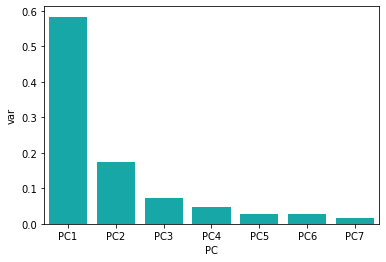

In [13]:
for i in range(1,10):
    pca=PCA(n_components=i)
    principalComponents = pca.fit_transform(df.drop(['Stay'],axis=1))
    if pca.explained_variance_ratio_.sum()>=0.95:  #gives required i for which total variance preserved is >=95%
        break
pca = PCA(n_components=i)
principalComponents = pca.fit_transform(df)
column_list=[]
for x in range(1,i+1):
    s="PC"+str(x)
    column_list.append(s)
principalDf = pd.DataFrame(data = principalComponents, columns = column_list)
finalDf = pd.concat([principalDf, df['Stay']], axis = 1)

#print(finalDf.head())
#print(pca.explained_variance_ratio_)

#Visualising Scree plots
df_plot = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':column_list})
sns.barplot(x='PC',y="var", 
           data=df_plot, color="c");


rem_df, test_df_1 = train_test_split(finalDf,0.2)
rem_df, test_df_2 = train_test_split(rem_df, 0.25)
rem_df, test_df_3 = train_test_split(rem_df, 0.33)
test_df_5, test_df_4 = train_test_split(rem_df, 0.50)

indices = test_df_1.index.tolist()
train_df_1 = finalDf.drop(indices)

indices = test_df_2.index.tolist()
train_df_2 = finalDf.drop(indices)

indices = test_df_3.index.tolist()
train_df_3 = finalDf.drop(indices)

indices = test_df_4.index.tolist()
train_df_4 = finalDf.drop(indices)

indices = test_df_5.index.tolist()
train_df_5 = finalDf.drop(indices)


#For training, we'll use Gaussian Naive Bayes since Primcipal Components arn continuous features

'''Performing 5 fold cross validation'''

X = (train_df_1.drop(['Stay'],axis=1)).values
y = train_df_1['Stay'].values

NB = gaussClf()
NB.fit(X,y)

X_test = (test_df_1.drop(['Stay'],axis=1)).values
y_pred = NB.predict(X_test)
test_y = test_df_1['Stay'].values
print(f"Accuracy 1 : {sum(y_pred==test_y)/X_test.shape[0]}")


X = (train_df_2.drop(['Stay'],axis=1)).values
y = train_df_2['Stay'].values

NB = gaussClf()
NB.fit(X,y)

X_test = (test_df_2.drop(['Stay'],axis=1)).values
y_pred = NB.predict(X_test)
test_y = test_df_2['Stay'].values
print(f"Accuracy 2 : {sum(y_pred==test_y)/X_test.shape[0]}")


X = (train_df_3.drop(['Stay'],axis=1)).values
y = train_df_3['Stay'].values

NB = gaussClf()
NB.fit(X,y)

X_test = (test_df_3.drop(['Stay'],axis=1)).values
y_pred = NB.predict(X_test)
test_y = test_df_3['Stay'].values
print(f"Accuracy 3 : {sum(y_pred==test_y)/X_test.shape[0]}")



X = (train_df_4.drop(['Stay'],axis=1)).values
y = train_df_4['Stay'].values

NB = gaussClf()
NB.fit(X,y)

X_test = (test_df_4.drop(['Stay'],axis=1)).values
y_pred = NB.predict(X_test)
test_y = test_df_4['Stay'].values
print(f"Accuracy 4 : {sum(y_pred==test_y)/X_test.shape[0]}")



X = (train_df_5.drop(['Stay'],axis=1)).values
y = train_df_5['Stay'].values

NB = gaussClf()
NB.fit(X,y)

X_test = (test_df_5.drop(['Stay'],axis=1)).values
y_pred = NB.predict(X_test)
test_y = test_df_5['Stay'].values
print(f"Accuracy 5 : {sum(y_pred==test_y)/X_test.shape[0]}")
